# Tree Classification with Deep Neural Network / Random Forest

## Dataset Preprocessing

The dataset preprocessing includes loading the raw npy dataset that has been created with the convertToNpy.py script. The loaded data is then separated into the X (input array) and Y (ground truth label). The input array is then normalized using the min-max scaler which is implemented in the NormalizeMatrix function. Then the data is split into training, validation, and test dataset.

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from TreeDataset import TreeDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn import init
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#convert image matrix to a numpy array and feed it into dataset

dataset = np.load("assets/new_data_preprocessed_30bands.npz", allow_pickle=True)

# X_train = train_data[:,:,:-1]
# X_train = np.c_[X_train[:][:][:].ravel().tolist()]
# y_train = train_data[:,:,-1].reshape(-1)

# X_test = test_data[:,:,:-1]
# X_test = np.c_[X_test[:][:][:].ravel().tolist()]
# y_test = test_data[:,:,-1].reshape(-1)

# np.savez("sample_train_interm",image=X_train,label=y_train)
# np.savez("sample_test_interm",image=X_test,label=y_test)


print(dataset['image'].shape)
print(dataset['labels'].shape)

image = dataset['image']
labels = dataset['labels']

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name())
else:
    device = torch.device('cpu')


(15657, 30, 5, 5)
(15657,)
NVIDIA GeForce GTX 1050


In [3]:
transform_img = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
])

In [4]:
#separate dataset into training, validation, and test dataset (stratified split)

X_train_val, X_test, y_train_val, y_test = train_test_split(image, encoded_labels, test_size=0.2, random_state=42,stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=28,stratify=y_train_val)

# np.savez("dataset/train_dataset.npz", data= X_train, labels= y_train)
# np.savez("dataset/val_dataset.npz", data= X_val, labels= y_val)
# np.savez("dataset/test_dataset.npz", data= X_test, labels= y_test)


X_train_mean = torch.from_numpy(np.mean(X_train, axis=(0,2,3)))
X_train_std = torch.from_numpy(np.std(X_train, axis=(0,2,3)))

normalized_X_train =  transforms.Normalize(X_train_mean, X_train_std)(torch.from_numpy(X_train))
normalized_X_val = transforms.Normalize(X_train_mean, X_train_std)(torch.from_numpy(X_val))
normalized_X_test = transforms.Normalize(X_train_mean, X_train_std)(torch.from_numpy(X_test))

batch_size = 32

train_dataset = TreeDataset(normalized_X_train,y_train,resize=False, transforms=transform_img)
val_dataset = TreeDataset(normalized_X_val, y_val,resize=False)
test_dataset = TreeDataset(normalized_X_test, y_test,resize=False)

print(np.unique(train_dataset.labels))
#weight classes
class_counts = np.bincount(train_dataset.labels.astype(int))
total_samples = len(train_dataset)
class_weights = 1.0 / (class_counts/ total_samples) #(class_counts/ total_samples)
print(class_counts)
print(total_samples)
# sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights, total_samples,replacement=True)

# Create data loaders for the training and test sets

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True)

[0 1 2 3 4 5 6 7 8 9]
[ 588  956  488  442  509 2303 1865  872  778  592]
9393


In [5]:
from experimental_models import ResNetExtended, ResNetModified

model = ResNetModified(30,10)

print(model)

ResNetModified(
  (resnet): ResNet(
    (conv1): Conv2d(30, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [15]:
# from experimental_models import FullyConnectedNetwork

# model = FullyConnectedNetwork(5,30,0.3,10)

In [16]:
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float()) # weight=torch.from_numpy(class_weights).float()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, factor=0.1,patience=5)
scheduler = CyclicLR(optimizer, base_lr=0.001,max_lr=0.0001,cycle_momentum=False)

In [17]:
# def train_loop(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     # Set the model to training mode - important for batch normalization and dropout layers
#     # Unnecessary in this situation but added for best practices
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         # Compute prediction and loss
#         pred = model(X.float())
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         # Calculate Loss
#         if batch % 100 == 0:
#             loss, current = loss.item(), (batch + 1) * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.float())
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.long())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
        

    return last_loss

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Model Training

The cell below implements the tensorboard utility from the torch library to save epoch results and best model

In [18]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/tree_class_trainer_{}'.format(timestamp))

epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

epochs_cum = []
tlosses_cum = []
vlosses_cum = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.float())
            vloss = loss_fn(voutputs, vlabels.long())
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    scheduler.step()
    
    tlosses_cum.append(avg_loss)
    vlosses_cum.append(avg_vloss)
    epochs_cum.append(epoch+1)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'fc_model_{}_{}.pth'.format(timestamp, epoch_number)
        torch.save(model, model_path)

    early_stopper = EarlyStopper(patience=3, min_delta=1)
    if early_stopper.early_stop(avg_loss):             
        break
    epoch_number += 1

EPOCH 1:


RuntimeError: Given groups=1, weight of size [64, 61, 5, 5], expected input[32, 5, 5, 61] to have 61 channels, but got 5 channels instead

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


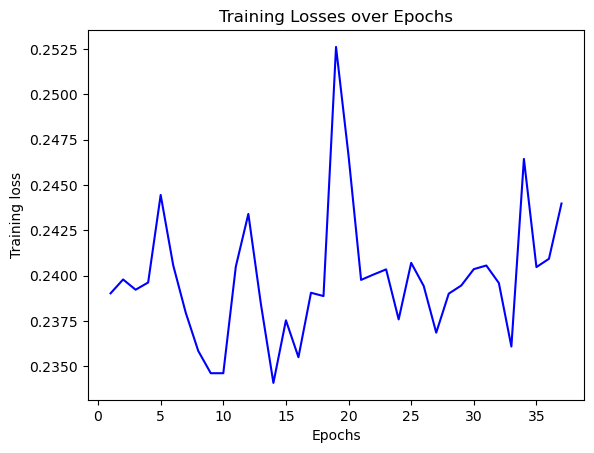

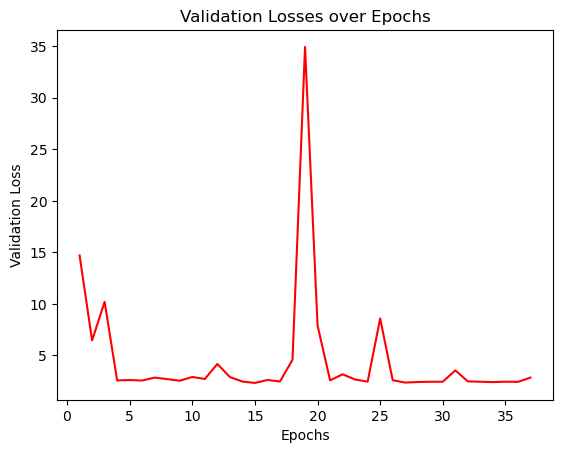

In [10]:
print(epochs_cum)
plt.figure()
plt.plot(epochs_cum, tlosses_cum, color='blue', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training Losses over Epochs')
plt.figure()
plt.plot(epochs_cum, vlosses_cum, color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Losses over Epochs')
plt.show()

In [11]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Abies alba': 0, 'Betula pendula': 1, 'Carpinus betulus': 2, 'Fraxinus excelsior': 3, 'Larix decidua': 4, 'Picea abies': 5, 'Pinus sylvestris': 6, 'Quercus petraea': 7, 'Quercus robur': 8, 'Sorbus aucuparia': 9}


# Grid Search

The code below was used to look for optimal hyperparameters (learning rate, epoch number). The cell is commented for now to test the obtained hyperparameters.

In [ ]:
# from skorch import NeuralNetClassifier
# from sklearn.model_selection import GridSearchCV
# from utils import create_search_run, save_best_hyperparam

# search_folder = create_search_run()

# # Learning parameters. 
# lr = 0.001
# epochs = 20
# print(f"Computation device: {device}\n")

# # Loss function. Required for defining `NeuralNetClassifier`
# criterion = nn.CrossEntropyLoss()


# # Instance of `NeuralNetClassifier` to be passed to `GridSearchCV` 
# net = NeuralNetClassifier(
#     module=model, max_epochs=epochs,
#     optimizer=optim.Adam,
#     criterion=criterion,
#     lr=lr, verbose=1
# )


# params = {
#     'lr': [0.005, 0.01, 0.1],
#     'max_epochs': list(range(10, 55, 20)),
# }

# """
# Define `GridSearchCV`.
# 4 lrs * 7 max_epochs * 4 module__first_conv_out * 3 module__first_fc_out
# * 2 CVs = 672 fits.
# """
# gs = GridSearchCV(
#     net, params, refit=False, scoring='accuracy', cv=2, verbose=1
# )

# counter = 0
# # Run each fit for 2 batches. So, if we have `n` fits, then it will
# # actually for `n*2` times. We have 672 fits, so total, 
# # 672 * 2 = 1344 runs.
# search_batches = 2
# """
# This will run `n` (`n` is calculated from `params`) number of fits 
# on each batch of data, so be careful.
# If you want to run the `n` number of fits just once, 
# that is, on one batch of data,
# add `break` after this line:
#     `outputs = gs.fit(image, labels)`

# Note: This will take a lot of time to run
# """
# for i, data in enumerate(train_loader):
#     counter += 1
#     image, labels = data
#     # image = image.to(device)
#     # labels = labels.to(device)
#     outputs = gs.fit(image.float(), labels.long())
#     # GridSearch for `search_batches` number of times.
#     if counter == search_batches:
#         break

# print('SEARCH COMPLETE')
# print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))
# save_best_hyperparam(gs.best_score_, f"./outputs/{search_folder}/best_param.yml")
# save_best_hyperparam(gs.best_params_, f"./outputs/{search_folder}/best_param.yml")

In [ ]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_loader, model, loss_fn, optimizer)
#     test_loop(test_loader, model, loss_fn)
# print("Done!")

Accuracy of the network on the test images: 11 %


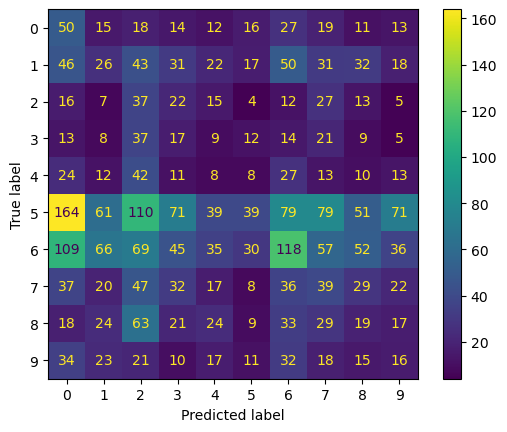

In [6]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
label_collector = []
prediction_collector = []
model = torch.load("fc_model_20230719_130151_38.pth")

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        label_collector.append(labels)
        prediction_collector.append(predicted)
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = le.inverse_transform(torch.cat(prediction_collector))
labels = le.inverse_transform(torch.cat(label_collector))

# for i in range(len(prediction_collector)):
#     input_pred_CM = torch.cat(torch.unsqueeze(prediction_collector[i]))
#     input_gt_CM = torch.cat(torch.unsqueeze(label_collector[i]))

cm = confusion_matrix(labels, predictions)
ConfusionMatrixDisplay(cm).plot()



In [7]:
from sklearn.metrics import f1_score

f1_scores = f1_score(labels, predictions, average='weighted')

print(f1_scores*100)

11.872565772547357


In [ ]:
torch.save(model.state_dict(),"D:\Programming\Python\machinelearning\DSEO\\resnet50_model_20230717_183329_94resnet50_model_20230717_183329_200")

In [15]:
torch.save(model,"D:\Programming\Python\machinelearning\DSEO\\fc_model_20230719_130151_38.pth")

In [17]:
from torchinfo import summary

# DOES A FORWARD PASS USING THE DEFAULT DEVICE (HERE CUDA) IF NOT SPECIFIED, CAUSED AN ERROR IN TRAINING LOOP BECAUSE WEIGHTS ARE IN CUDA AND INPUTS ARE IN CPU

summary(model, input_size=(batch_size, 30, 5, 5))


Layer (type:depth-idx)                        Output Shape              Param #
ResNetExtended                                [32, 10]                  --
├─Sequential: 1-1                             [32, 3, 20, 20]           --
│    └─Conv2d: 2-1                            [32, 64, 5, 5]            17,344
│    └─BatchNorm2d: 2-2                       [32, 64, 5, 5]            128
│    └─ReLU: 2-3                              [32, 64, 5, 5]            --
│    └─Conv2d: 2-4                            [32, 128, 5, 5]           73,856
│    └─BatchNorm2d: 2-5                       [32, 128, 5, 5]           256
│    └─ReLU: 2-6                              [32, 128, 5, 5]           --
│    └─Conv2d: 2-7                            [32, 3, 5, 5]             3,459
│    └─BatchNorm2d: 2-8                       [32, 3, 5, 5]             6
│    └─ReLU: 2-9                              [32, 3, 5, 5]             --
│    └─Upsample: 2-10                         [32, 3, 20, 20]           --
├─ResNet